In [3]:
!pip install blitz-bayesian-pytorch --quiet

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 48.4/48.4 kB 3.8 MB/s eta 0:00:00


In [19]:
#Google Colab Only
#from google.colab import drive
#drive.mount('/content/drive')

#colab only!
from google.colab import drive
import os
drive.mount('/content/drive', force_remount=True)
os.chdir('/content/')
os.listdir('/content/')


['.config', 'drive', 'preprocessed_small.zip', 'sample_data']

In [21]:
#colab only
!pip3 install -r requirements.txt
!pip3 install gdown
!mkdir data && cd data
!gdown 1WUgfFip5xvxQV-RqWRaHCRYuCwqBCGL7
!unzip -FF preprocessed_small

Streaming output truncated to the last 5000 lines.
  inflating: preprocessed/Pantropical Spotted Doplhin/9400806C.pt  
  inflating: preprocessed/Pantropical Spotted Doplhin/9400806D.pt  
  inflating: preprocessed/Pantropical Spotted Doplhin/9400806E.pt  
  inflating: preprocessed/Pantropical Spotted Doplhin/9400806F.pt  
  inflating: preprocessed/Pantropical Spotted Doplhin/9400806G.pt  
  inflating: preprocessed/Pantropical Spotted Doplhin/9400806H.pt  
  inflating: preprocessed/Pantropical Spotted Doplhin/9400806I.pt  
  inflating: preprocessed/Pantropical Spotted Doplhin/9400806J.pt  
  inflating: preprocessed/Pantropical Spotted Doplhin/9400806K.pt  
  inflating: preprocessed/Pantropical Spotted Doplhin/9400806L.pt  
  inflating: preprocessed/Pantropical Spotted Doplhin/9400806M.pt  
  inflating: preprocessed/Pantropical Spotted Doplhin/9400806N.pt  
  inflating: preprocessed/Pantropical Spotted Doplhin/9400806O.pt  
  inflating: preprocessed/Pantropical Spotted Doplhin/9400806P.pt

Scanning directories...


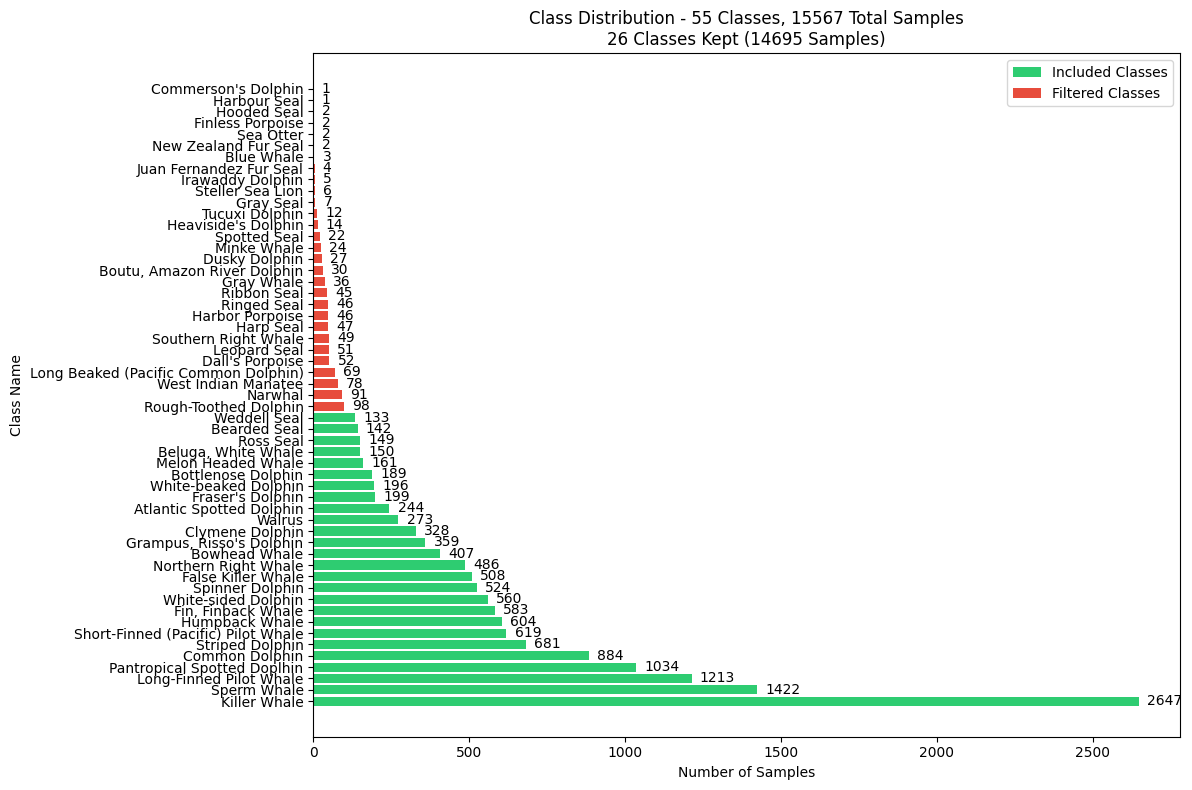

<Figure size 1200x1650 with 0 Axes>

Dataset Summary:
  - Total classes: 55
  - Classes meeting min_samples threshold: 26
  - Total samples: 15567
  - Kept samples: 14695 (94.4%)
  - Min samples per class: 1
  - Max samples per class: 2647
  - Avg samples per class: 283.0
Class distribution in split:
  - Atlantic Spotted Dolphin: Train 195/244 (79.9%), Test 49/244 (20.1%)
  - Bearded Seal: Train 114/142 (80.3%), Test 28/142 (19.7%)
  - Beluga, White Whale: Train 120/150 (80.0%), Test 30/150 (20.0%)
  - Bottlenose Dolphin: Train 151/189 (79.9%), Test 38/189 (20.1%)
  - Bowhead Whale: Train 326/407 (80.1%), Test 81/407 (19.9%)
  - Clymene Dolphin: Train 262/328 (79.9%), Test 66/328 (20.1%)
  - Common Dolphin: Train 707/884 (80.0%), Test 177/884 (20.0%)
  - False Killer Whale: Train 407/508 (80.1%), Test 101/508 (19.9%)
  - Fin, Finback Whale: Train 466/583 (79.9%), Test 117/583 (20.1%)
  - Fraser's Dolphin: Train 159/199 (79.9%), Test 40/199 (20.1%)
  - Grampus, Risso's Dolphin: Train 287/359 (79.9%), Test 72/359 (20.1%)
  

100%|██████████| 11756/11756 [00:27<00:00, 430.78it/s]


Computing normalization parameters...
Normalization parameters:
  - Mean: tensor([4.3429])
  - Std: tensor([17.7344])
Loading 2939 tensors into memory...


100%|██████████| 2939/2939 [00:05<00:00, 519.52it/s]


In [1]:

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from blitz.modules import BayesianLinear
from blitz.utils import variational_estimator
from blitz.losses import kl_divergence_from_nn
from dataset import create_datasets
from baseline_model import MarineMammalBNN
import numpy as np

root_dir = f"data\\preprocessed"
train_dataset, test_dataset, class_to_idx = create_datasets(
    root_dir=root_dir,
    test_size=0.2,
    min_samples=100,
    random_state=42
)

train_loader = DataLoader(train_dataset, batch_size=3074, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=1)

class_weights = train_dataset.get_class_weights()
NUM_CLASSES = len(class_to_idx)


In [2]:

device = "cuda" if torch.cuda.is_available() else "cpu"
#device = "cpu"
print(device)
model = MarineMammalBNN(num_classes=NUM_CLASSES).to(device)
criterion = nn.CrossEntropyLoss(weight=class_weights.to(device))
optimizer = torch.optim.Adam(model.parameters(), lr=0.0004)

print("kl_loss exists:", hasattr(model, "kl_loss"))


cpu
kl_loss exists: False


In [3]:

def elbo_loss(model, x, y, criterion, kl_weight):
    pred = model(x)
    ce = criterion(pred, y)
    kl = kl_divergence_from_nn(model)
    return ce + kl_weight * kl


In [74]:
import time
import datetime

EPOCHS = 100
KL_WEIGHT = 0.01
# Training loop with time and GPU memory tracking
start_time = time.time()

model.train()
for epoch in range(EPOCHS):
    epoch_start = time.time()
    model.train()
    total_loss = 0
    for x, y in train_loader:
        x, y = x.to(device), y.to(device)
        optimizer.zero_grad()
        loss = elbo_loss(model, x, y, criterion, KL_WEIGHT)
        loss.backward()
        optimizer.step()
        learning_rate = optimizer.param_groups[0]['lr']
        total_loss += loss.item()
    epoch_loss = total_loss / len(train_loader)
    epoch_time = time.time() - epoch_start

    # Get GPU memory usage
    gpu_memory_used = 0
    if torch.cuda.is_available():
        # Get current GPU memory usage in MB
        gpu_memory_used = torch.cuda.max_memory_allocated() / (1024 ** 2)
        # Reset peak memory stats for next epoch
        torch.cuda.reset_peak_memory_stats()
    # Format time as hours:minutes:seconds
    epoch_time_str = str(datetime.timedelta(seconds=int(epoch_time)))
    total_time_str = str(datetime.timedelta(seconds=int(time.time() - start_time)))

    print(f'Epoch {epoch+1}/{EPOCHS}, Loss: {epoch_loss:.4f}, Time: {epoch_time_str}, GPU Memory: {gpu_memory_used:.1f} MB, Total Time: {total_time_str}')


Epoch 1/100, Loss: 316.5844, Time: 0:00:02, GPU Memory: 11116.7 MB, Total Time: 0:00:02
Epoch 2/100, Loss: 315.8132, Time: 0:00:02, GPU Memory: 11116.7 MB, Total Time: 0:00:04
Epoch 3/100, Loss: 314.3968, Time: 0:00:02, GPU Memory: 11116.7 MB, Total Time: 0:00:07
Epoch 4/100, Loss: 313.4935, Time: 0:00:02, GPU Memory: 11116.7 MB, Total Time: 0:00:09
Epoch 5/100, Loss: 312.4150, Time: 0:00:02, GPU Memory: 11116.7 MB, Total Time: 0:00:12
Epoch 6/100, Loss: 310.9678, Time: 0:00:02, GPU Memory: 11147.5 MB, Total Time: 0:00:14
Epoch 7/100, Loss: 310.2361, Time: 0:00:02, GPU Memory: 11147.5 MB, Total Time: 0:00:16
Epoch 8/100, Loss: 309.4945, Time: 0:00:02, GPU Memory: 11116.7 MB, Total Time: 0:00:19
Epoch 9/100, Loss: 308.7141, Time: 0:00:02, GPU Memory: 11116.7 MB, Total Time: 0:00:21
Epoch 10/100, Loss: 308.3774, Time: 0:00:02, GPU Memory: 11116.7 MB, Total Time: 0:00:24
Epoch 11/100, Loss: 307.4798, Time: 0:00:02, GPU Memory: 11116.7 MB, Total Time: 0:00:26
Epoch 12/100, Loss: 306.0453, 

In [76]:
torch.save(model.state_dict(), f"marine_bnn.pt")

In [4]:

def predict_with_uncertainty(model, x, n_samples=30):
    model.eval()
    preds = [model(x.to(device)).softmax(dim=1).detach() for _ in range(n_samples)]
    stacked = torch.stack(preds)
    return stacked.mean(dim=0), stacked.std(dim=0)


In [6]:
#load model for evaluation: 
model.load_state_dict(torch.load('ModelWeights/marine_bnn.pt', map_location=torch.device('cpu')))
model.eval()

MarineMammalBNN(
  (conv1): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool1): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool2): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (inception3a): InceptionBlock(
    (branch1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1))
    (branch2_1): Conv2d(64, 48, kernel_size=(1, 1), stride=(1, 1))
    (branch2_2): Conv2d(48, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (branch3_1): Conv2d(64, 16, kernel_size=(1, 1), stride=(1, 1))
    (branch3_2): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (branch3_3): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))

In [ ]:

correct_list = []
confidence_list = []
entropy_list = []
std_list = []

all_preds = []
all_targets = []
counter = 0
print(len(test_loader.dataset))
with torch.no_grad():
  for x, y in test_loader:
      counter += 1
      if counter % 100 == 0:
        print(counter)
      x = x.to(device)
      y = y.to(device)
      mean_pred, std_pred = predict_with_uncertainty(model, x, n_samples=30)
      pred_label = mean_pred.argmax(dim=1).item()
      true_label = y.item()
      confidence = mean_pred.max().item()
      entropy = -torch.sum(mean_pred * torch.log(mean_pred + 1e-8)).item()
      std = std_pred.max().item()
      correct = int(pred_label == true_label)

      correct_list.append(correct)
      confidence_list.append(confidence)
      entropy_list.append(entropy)
      std_list.append(std)
      # Store predictions and targets
      all_preds.append(mean_pred)
      all_targets.append(true_label)



mean_accuracy = np.mean(correct_list)
mean_confidence = np.mean(confidence_list)
mean_entropy = np.mean(entropy_list)
mean_std = np.mean(std_list)

print(f"Mean Accuracy: {mean_accuracy:.4f}")
print(f"Mean Predictive Confidence: {mean_confidence:.4f}")
print(f"Mean Predictive Entropy: {mean_entropy:.4f}")
print(f"Mean Predictive Std: {mean_std:.4f}")


2939
100
200
300
400
500
600
700
800
900
1000
1100
1200
1300
1400
1500
1600
1700
1800
1900
2000
2100
2200
2300
2400
2500
2600
2700
2800
2900


ValueError: Classification metrics can't handle a mix of multiclass and unknown targets

In [36]:
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, classification_report
print(all_targets)
print(len(all_preds))
pred_labels = []
for pred in all_preds:
    label = pred.argmax(dim=1).item()
    pred_labels.append(label)
#print()
precision, recall, f1, _ = precision_recall_fscore_support(all_targets, pred_labels, average='weighted', zero_division=0)
print(precision, recall, f1)
print(len(correct_list))

[10, 13, 25, 6, 12, 12, 12, 13, 15, 12, 20, 6, 10, 15, 12, 18, 22, 16, 13, 6, 12, 19, 20, 4, 15, 6, 12, 19, 12, 12, 20, 12, 17, 11, 13, 4, 12, 13, 4, 8, 13, 13, 3, 4, 10, 8, 25, 7, 12, 0, 9, 10, 12, 12, 25, 5, 19, 4, 18, 19, 4, 15, 19, 1, 20, 19, 12, 16, 19, 12, 19, 12, 11, 0, 24, 12, 20, 12, 12, 24, 25, 11, 20, 16, 12, 15, 10, 18, 4, 18, 20, 22, 6, 12, 19, 8, 25, 19, 6, 3, 13, 16, 16, 4, 17, 20, 19, 19, 13, 18, 19, 12, 8, 25, 14, 16, 19, 13, 16, 0, 8, 13, 12, 11, 12, 8, 9, 6, 7, 0, 5, 13, 12, 8, 5, 1, 19, 0, 4, 12, 17, 13, 5, 4, 8, 13, 25, 19, 11, 18, 12, 16, 15, 12, 4, 4, 19, 18, 12, 19, 15, 25, 16, 12, 12, 4, 19, 2, 12, 12, 19, 5, 8, 12, 13, 6, 5, 12, 21, 25, 12, 16, 16, 5, 16, 11, 19, 12, 6, 4, 12, 10, 12, 13, 12, 12, 19, 25, 12, 4, 2, 5, 15, 23, 16, 4, 20, 12, 13, 20, 25, 10, 12, 9, 19, 16, 11, 19, 22, 21, 12, 19, 16, 21, 21, 10, 11, 21, 4, 12, 15, 10, 19, 13, 21, 7, 25, 25, 11, 7, 7, 12, 18, 10, 13, 12, 16, 7, 12, 0, 22, 1, 13, 23, 25, 4, 19, 19, 14, 11, 12, 19, 12, 19, 16, 9, 22

Expected Calibration Error (ECE): 0.0633


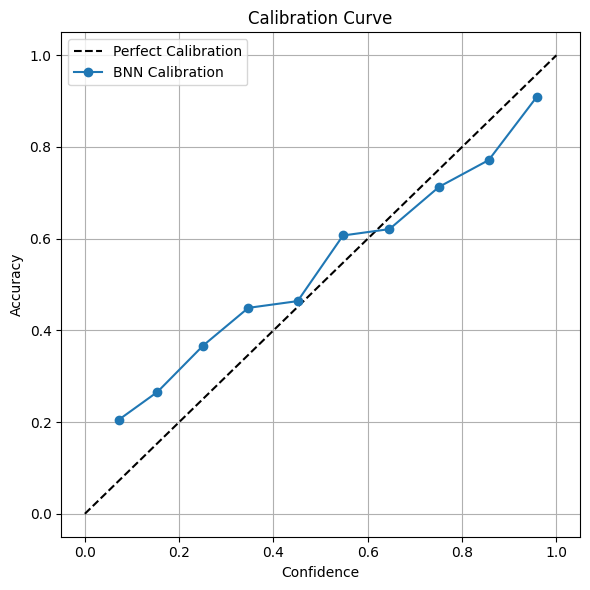

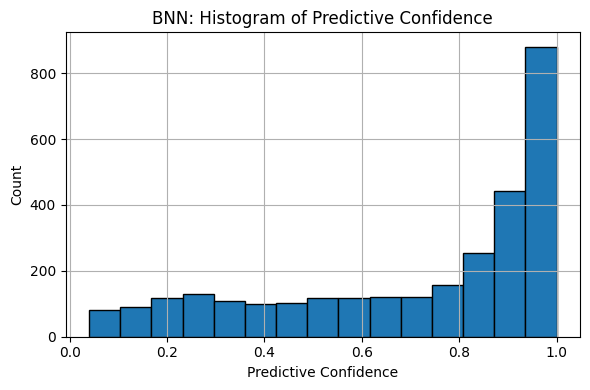

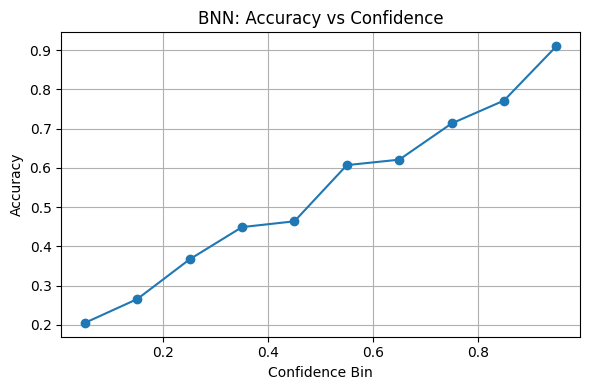

In [62]:
import matplotlib.pyplot as plt
import numpy as np

# === ECE Computation ===
def compute_ECE(confidences, corrects, num_bins=10):
    bins = np.linspace(0, 1, num_bins + 1)
    bin_indices = np.digitize(confidences, bins) - 1
    ece = 0.0
    total = len(confidences)
    for i in range(num_bins):
        bin_mask = bin_indices == i
        if np.any(bin_mask):
            acc = np.mean(np.array(corrects)[bin_mask])
            conf = np.mean(np.array(confidences)[bin_mask])
            ece += np.abs(acc - conf) * np.sum(bin_mask) / total
    return ece

ece_score = compute_ECE(confidence_list, correct_list)
print(f"Expected Calibration Error (ECE): {ece_score:.4f}")

# === Calibration Curve Plot ===
def plot_calibration_curve(confidences, corrects, num_bins=10):
    bins = np.linspace(0.0, 1.0, num_bins + 1)
    bin_centers = (bins[:-1] + bins[1:]) / 2
    accs = []
    confs = []

    bin_indices = np.digitize(confidences, bins) - 1
    for i in range(num_bins):
        idxs = [j for j in range(len(confidences)) if bin_indices[j] == i]
        if idxs:
            bin_conf = np.mean([confidences[j] for j in idxs])
            bin_acc = np.mean([correct_list[j] for j in idxs])
        else:
            bin_conf, bin_acc = 0, 0
        confs.append(bin_conf)
        accs.append(bin_acc)

    plt.figure(figsize=(6, 6))
    plt.plot([0, 1], [0, 1], 'k--', label="Perfect Calibration")
    plt.plot(confs, accs, marker='o', label="BNN Calibration")
    plt.xlabel("Confidence")
    plt.ylabel("Accuracy")
    plt.title("Calibration Curve")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

plot_calibration_curve(confidence_list, correct_list)

# === Confidence Histogram ===
plt.figure(figsize=(6, 4))
plt.hist(confidence_list, bins=15, edgecolor='black')
plt.xlabel("Predictive Confidence")
plt.ylabel("Count")
plt.title("BNN: Histogram of Predictive Confidence")
plt.grid(True)
plt.tight_layout()
plt.show()

# === Accuracy vs Confidence Bin Plot ===
bins = np.linspace(0.0, 1.0, 11)
bin_indices = np.digitize(confidence_list, bins) - 1
accuracies = []

for i in range(10):
    bin_correct = [correct_list[j] for j in range(len(correct_list)) if bin_indices[j] == i]
    acc = np.mean(bin_correct) if bin_correct else 0
    accuracies.append(acc)

bin_centers = (bins[:-1] + bins[1:]) / 2
plt.figure(figsize=(6, 4))
plt.plot(bin_centers, accuracies, marker='o')
plt.xlabel("Confidence Bin")
plt.ylabel("Accuracy")
plt.title("BNN: Accuracy vs Confidence")
plt.grid(True)
plt.tight_layout()
plt.show()
